In [1]:
import torch
import torch.nn.functional as F
import torchvision
import numpy as np
import matplotlib.pyplot as plt

In [2]:
img = torchvision.io.read_image("lab1.png")
img = img / 255

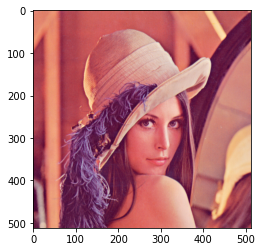

In [3]:
plt.imshow(img.permute(1, 2, 0))

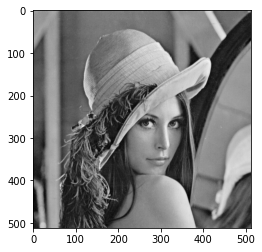

In [4]:
mean_filter = torch.ones(1, 3, 1, 1)
img = F.conv2d(img.unsqueeze(0), mean_filter, padding=0, stride=1).squeeze(0)

plt.imshow(img.permute(1, 2, 0), cmap="gray")

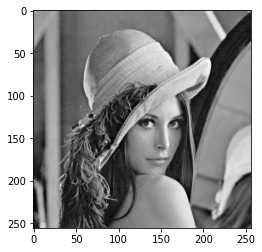

In [5]:
new_img1 = F.avg_pool2d(img.unsqueeze(0), (2, 2)).squeeze(0)
plt.imshow(new_img1.permute(1, 2, 0), cmap="gray")

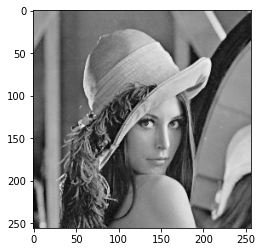

In [6]:
new_img2 = F.max_pool2d(img.unsqueeze(0), (2, 2)).squeeze(0)
plt.imshow(new_img2.permute(1, 2, 0), cmap="gray")

In [7]:
img = F.avg_pool2d(img.unsqueeze(0), (2, 2)).squeeze(0)

In [8]:
def gaussian_kernel(l=3, sig=1.):
    x = np.linspace(-(l - 1) / 2., (l - 1) / 2., l)
    gauss = np.exp(-0.5 * np.square(x) / np.square(sig))
    kernel = np.outer(gauss, gauss)
    return torch.tensor(kernel / np.sum(kernel), dtype=torch.float32).unsqueeze(0)

In [9]:
kernel = gaussian_kernel()
kernel

tensor([[[0.0751, 0.1238, 0.0751],
         [0.1238, 0.2042, 0.1238],
         [0.0751, 0.1238, 0.0751]]])

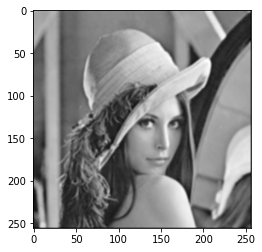

In [10]:
img = F.conv2d(img.unsqueeze(0), kernel.unsqueeze(0), stride=1, padding=1).squeeze(0)
plt.imshow(img.permute(1, 2, 0), cmap="gray")

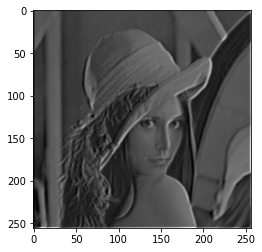

In [11]:
kernel1 = torch.tensor([[[1, 2, 1], [0, 0, 0], [-1, -2, -1]]], dtype=torch.float32)
kernel2 = torch.tensor([[[1, 0, 1], [2, 0, -2], [1, 0, -1]]], dtype=torch.float32)
sobel1 = F.conv2d(img.unsqueeze(0), kernel1.unsqueeze(0), stride=1, padding=1).squeeze(
    0
)
sobel2 = F.conv2d(img.unsqueeze(0), kernel2.unsqueeze(0), stride=1, padding=1).squeeze(
    0
)

sobel_mag = torch.sqrt(torch.square(sobel1) + torch.square(sobel2))
sobel_dir = torch.arctan2(sobel1, sobel2)

plt.imshow(sobel_mag.permute(1, 2, 0), cmap="gray")

In [12]:
def non_max_suppression(img, D):
    M, N = img.shape
    Z = np.zeros((M,N), dtype=np.int32)
    angle = D * 180. / np.pi
    angle[angle < 0] += 180
    for i in range(1,M-1):
        for j in range(1,N-1):
            try:
                q = 255
                r = 255
                #angle 0
                if (0 <= angle[i,j] < 22.5) or (157.5 <= angle[i,j] <= 180):
                    q = img[i, j+1]
                    r = img[i, j-1]
                #angle 45
                elif (22.5 <= angle[i,j] < 67.5):
                    q = img[i+1, j-1]
                    r = img[i-1, j+1]
                #angle 90
                elif (67.5 <= angle[i,j] < 112.5):
                    q = img[i+1, j]
                    r = img[i-1, j]
                #angle 135
                elif (112.5 <= angle[i,j] < 157.5):
                    q = img[i-1, j-1]
                    r = img[i+1, j+1]
                if (img[i,j] >= q) and (img[i,j] >= r):
                    Z[i,j] = img[i,j]
                else:
                    Z[i,j] = 0
            except IndexError as e:
                pass
    return Z

In [21]:
edges = torch.tensor(non_max_suppression(sobel_mag.squeeze(0), sobel_dir.squeeze(0)), dtype=torch.float32)

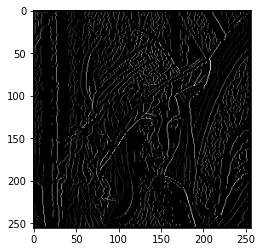

In [22]:
plt.imshow(edges, cmap="gray")

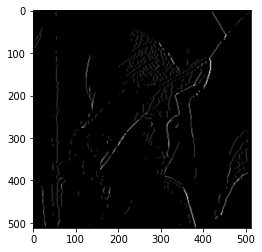

In [51]:
filtered_edges = F.relu(edges - 3)
filtered_edges = torchvision.transforms.Resize(512)(filtered_edges.unsqueeze(0))
filtered_edges = filtered_edges.squeeze(0).squeeze(0)
plt.imshow(filtered_edges, cmap="gray")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


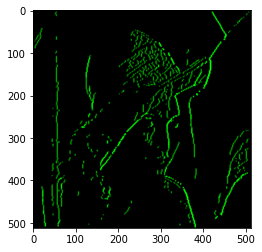

In [52]:
green_edges = torch.zeros((3, 512, 512))
green_edges[1, :, :] = filtered_edges
plt.imshow(green_edges.permute(1, 2, 0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


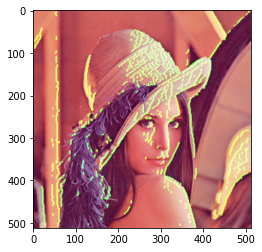

In [53]:
import cv2
final_edges = np.array(green_edges.permute(1, 2, 0))
raw_img = np.array(torchvision.io.read_image("lab1.png").permute(1, 2, 0) / 255)
result =  cv2.addWeighted(raw_img,1,final_edges,3,0)
plt.imshow(result)